In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib.preprocess.envelope
import os

In [ ]:
# nt = 255
# t_on = 100
# szr_lngth = 10
# t_off = t_on + szr_lngth
# lambda_on = 2.0
# lambda_off = 2.0
# dt = 0.1
# tm_pts = dt*np.arange(0,nt)
# x = (1/(1+np.exp(-lambda_on*(tm_pts-t_on))))*(1/(1+np.exp(lambda_off*(tm_pts-t_off))))
# plt.figure(figsize=(25,5))
# plt.plot(x,'rx')

In [2]:
data_dir = 'datasets/syn_data/id001_bt'
results_dir = 'results/exp13.1'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

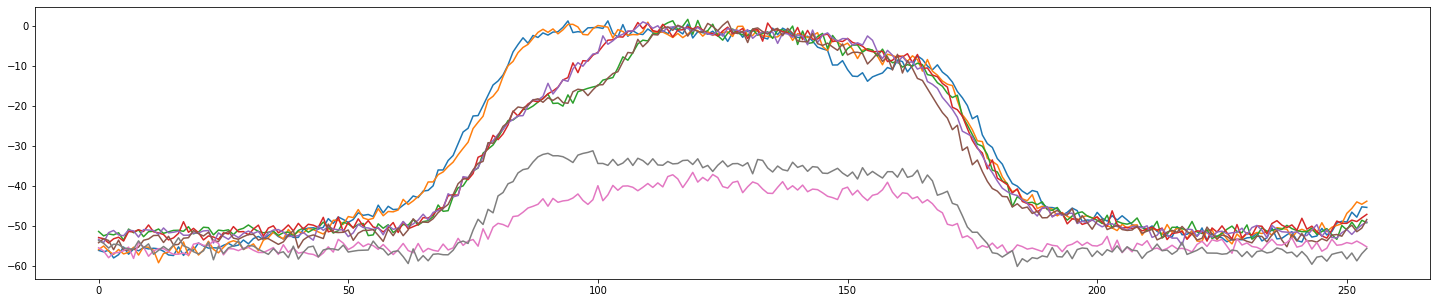

In [3]:
syn_data = np.load(os.path.join(data_dir, "syn_tvb_ez=48-79_pz=11-17-22-75.npz"))
start_idx = 0
end_idx = 3000
src_sig = syn_data['src_sig'][start_idx:end_idx,0,:,0] + syn_data['src_sig'][start_idx:end_idx,3,:,0]
src_log_pwr = lib.preprocess.envelope.compute_slp_syn(src_sig, samp_rate=256, win_len=100, hpf=10, lpf=1.0, logtransform=True)
# plt.figure(figsize=(25,5))
# plt.plot(src_sig[:, 100])
slp = src_log_pwr[250:2800:10, [48,79,11,17,22,75,100,130]]
slp = slp + np.random.normal(0,1,slp.shape)
# slp = np.ones([250, 2]) + np.random.normal(0,1,slp.shape)
# slp = slp
plt.figure(figsize=(25,5))
plt.plot(slp)
plt.savefig(os.path.join(results_dir, "figures", "fit_trgt.png"))

In [ ]:
data = dict()
data['nn'] = slp.shape[1]
data['nt'] = slp.shape[0]
data['x'] = slp
lib.io.stan.rdump(os.path.join(results_dir, "Rfiles", "fit_data.R"), data)

param_init = dict()
param_init['t_on'] = 8*np.ones(data['nn'])
param_init['t_off'] = 10*np.ones(data['nn'])
param_init['lambda_on'] = 1.0*np.ones(data['nn'])
param_init['lambda_off'] = 1.0*np.ones(data['nn'])
param_init['alpha'] = 1.0*np.ones(data['nn'])
param_init['beta'] = 0.0*np.ones(data['nn'])
param_init['dt'] = 0.1*np.ones(data['nn'])
param_init['eps_slp'] = 1.0*np.ones(data['nn'])

lib.io.stan.rdump(os.path.join(results_dir, "Rfiles", "param_init.R"), param_init)

In [ ]:
%%bash
stancompile.sh infer_szr_prpgtn_sigmoid

In [ ]:
%%bash -s "$results_dir"

STAN_FNAME="infer_szr_prpgtn_sigmoid"
RESULTS_DIR=$1
INPUT_RFILE="fit_data.R"
FNAME_SUFFIX="sigmoid_infer"
DELTA=0.9
MAX_DEPTH=15

for i in {1..1};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=200 num_warmup=1000 \
save_warmup=0 adapt delta=${DELTA} algorithm=hmc engine=nuts max_depth=${MAX_DEPTH} \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [ ]:
import lib.plots.stan

chains = [1]
params = ['t_on', 't_off', 'lambda_on', 'lambda_off', 'alpha', 'beta', 'dt']
for chain_no in chains:
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_sigmoid_infer_chain{chain_no}.csv'], nsampling=200, nwarmup=0)
    x = pstr_samples['x_mu'].mean(axis=0)
    lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_sigmoid_infer_chain{chain_no}.png')
    lib.plots.stan.pair_plots(samples=pstr_samples, params=params, 
                              figname=f'{results_dir}/figures/params_pair_plots_sigmoid_infer_chain{chain_no}.png', sampler='HMC')
    plt.figure(figsize=(25,5))
    plt.plot(x, 'r')
    plt.plot(data['x'])

In [ ]:
plt.figure(figsize=(20,5))
for i in range(data['nn']):
    plt.subplot(1,3,i+1)
    plt.hist(pstr_samples['t_on'][:,i])

In [ ]:
mu = 5
sigma = 1
t = np.random.lognormal(mu, sigma, 1000)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(np.log(t))
plt.subplot(132)
plt.hist(t, bins=100)
plt.subplot(133)
plt.plot(np.mean(t), 'rx')